<a href="https://colab.research.google.com/github/pacayton/Causal_Inference_Sessions/blob/main/Matching_RUsersGroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matching Methods for Estimating Causal Effects in R
## Peter Julian Cayton
### Associate Professor of Forecasting Analytics and Statistics
### School  of Statistics, University of the Philippines Diliman
### [LinkedIn](https://www.linkedin.com/in/peter-julian-cayton-90a0a524/), [Google Scholar](https://scholar.google.com/citations?user=KtH_mGEAAAAJ),  [X (formerly Twitter)](https://twitter.com/PJACaytonPhD)

---

In this Google Colab notebook, we will talk about the different methods of matching data that helps us estimate and extract the effect or impact of interventions, treatments, or policies.

First, we will talk about causal inference, a budding field in data science and analytics, and its philosophical foundations and basic concepts that will get us started.

The next topic that we will talk about is matching methods and how it is used in causal inference. We will discuss about its basic framework and the multiple settings and specifications one can have with matching.

This will be followed by some sample runs from existing openly-available data.

I will also share some references for those who would like to learn more about matching and causal inference in general that also use R. These references are great for those beginning their journey in causal inference.

---

# 1) Causal Inference

Causal inference is a field of data analysis that involves a system of methods, algorithms, and approaches for extracting and estimating the causal or treatment effects of interventions, treatments, or policies and making further inferences or generalizations about those effects on a wider scope or population (Bauer 2020; O'Grady 2020).

## Basic Terms in Causal Inference

### Dependent Variable

- "outcome" or "response" variable
- variable of interest of which its changes would be explained by probable causes.
- Denoted as the variable Y.
- May be discrete/categorical (e.g., Cured/Not, Yes/No, None/Asymptomatic/Mild/Severe/Critical)
- May be numerical (Income, Price, Temperature)
- May be univariate or multivariate; we generally discuss assuming univariate response.

### Treatment Variable
- Also known as “intervention”, “exposure”, “policy”
- Variable that is assumed to and is tested for being the cause for changes to outcome or response
- Denoted by D, T, or X
- May be binary (Experimental/Control), categorical (Method A/B/C), continuous (different doses), or multivariate (multiple medicines with differing doses).
- Treatment levels = different values of the treatment variable.

### Covariates
- Also known as control variables
- Variable that is assumed to influence the dependent variable but is not generally tested for being the cause for changes to outcome or response
- Denoted by Z or X
- Generally, they are numerical; categorical variables of similar nature are called “blocking variables” in experimental designs

### Error Terms
- Sometimes known as residuals, residues, idiosyncratic component, random component
- Generally denoted by $ϵ$ or U

### Confounders
- Variable that may influence both treatment variable and response variable.
- Denoted by any Latin letter
- Some confounders may be observed and can be included as terms in a statistical model
- Often, confounders may be unobserved and may make our causal conclusions invalid or biased.

I will skip some other concepts in causal inference, e.g., Potential Outcomes, Causal Directed Acyclic Graphs, the Fundamental Problem of Causal Inference, Stable Unit Treatment Value Assumption (SUTVA), and Validity Concerns in Inference.

I highly suggest reading the references for more details.

---


## Correlation does not imply causation...

Also known as "cum hoc ergo propter hoc", meaning "with this, therefore because of this" fallacy. This is because correlation and association measures between two variables, say X and Y, would manifest because of the following reasons:

1. X causes Y ($ X → Y $)
2. Y causes X ($ Y → X $)
3. X and Y cause each other, also known as endogeneity or biconditionality ($ X ↔ Y$)
4. X and Y are linked to a third variable, Z, which is a confounding variable ($ X ← Z → Y $)

The problem is that with correlation measures, the direction of causation or its structure is indistinguishable without proper tools to break down which reason.

One of the greatest examples of this is Spurious Correlation website by Tyler Vigen (https://www.tylervigen.com/spurious-correlations)

## ... however, no correlation does not necessarily mean no causation

It is possible to have (Cunningham 2021):

1. Nonlinear systems for causality (e.g., quadratic, sinusoidal)
2. Complex systems with multiple variables muddying up the causal link
3. In time series data, delays in impact where the causal effects are not correlated to occurrence of interventions.


---


## Scope of Causality for Discussion

For our discussion, the type of causality that we will be talking about has the following scope

1. *Temporality* = only 1 direction of causality, in which the cause happens first before the effect. We will set aside endogeneity or two-directional causality (Bauer 2020).

2. *Probabilistic Causality* = for events A and B, if doing the action A increases the probability of event B, then A probabilistically causes B (Bauer 2020).

$$ P(B|do(A), Z =z) > P(B|Z=z)$$

---


## Five Canons in Proving Causation

Here are some ways that we may be able to conclude or prove causation (Mill 1846; quoted in Brumback 2022):

1. *Method of Agreement*: if 2 or more instances of the phenomenon under investigation have only 1 common curcumstance, then this common circumstance is the cause or effect of the given phenomenon.
> Essentially, an example of this commmon instance would be receiving similar treatment.

2. *Method of Difference*: Given an instance in which the phenomenon under investigation occurs and another instance in which the phenomenon does not occur, if these two instances have everything else in common except for one feature, then the feature that is not common to them may be an effect, a cause, or a necessary part of the cause.
> This means that to extract or estimate causal or treatment effect, it is important that other factors or variables are similar between units from the treatment and the control groups. This is an important principle for matching.

3. *Joint Method of Agreement and Difference*: If two or more instances of the phenomenon in which the phenomenon occurs have 1 feature in common, while 2 or more instances in which it does not occurs does not have the feature, then the feature may be the effect, cause, or a necessary part of the cause.
> This just combines the first 2 canons and thus is self-explanatory.

4. *Method of Residues*: Subtracting any previously known effect or impact other factors or antecedents, the residue/residual of the phenomenon is the effect of remaining antecedents or causes.
> This just opens the idea that we can refine estimation of causal or treatment effects by taking account of other factors, but still in keeping with the first 3 canons.

5. *Method of Concomitant Variations*: Whatever phenomenon varies in any manner whenever another phenomenon varies in some particular manner is either the cause, the effect, or connected with it through some fact of causation.
> This is similar to the concept that underlies analysis of variance decomposition and R-Square, where the variability of the outcome can be explained by the variability or behavior of input or independent variables.

You might notice that common in these canons that they mention the phrase "may be the cause or the effect", in which temporality plays a factor to determine whether it is a cause or an effect.

---

## The Estimation Problem for Causal Inference

Often, when we think about estimating the average treatment effect [ATE] between the treatment ($T =1$) and the control ($T=0$) groups, we may start with the simple difference of group means [SDGM].

However, it is shown by Cunningham (2021) that SDGM is potentially biased and can be decomposed into:

$$ SDGM = ATE + Selection Bias + Heterogenous Treatment Effect Bias $$

In a balanced research design, heterogenous treatment effect can become 0, so a well-planned experiment or research design is necessary to address this.

Selection bias can be eliminated by randomization of assigned treatment so properly designed randomized experiments already have this type of bias as 0.

However for observational studies, selection bias is still problematic as researchers are not able to randomize the group assignment of units.

In addressing selection bias, often an alternative paradigm of inference is used, and matching methods helps in addressing this bias.


---


## Selection on Observables

In doing causal research, the gold standard to estimate causal effect would be a properly designed experiment in which (Cunningham 2021; O'Grady 2020):

1. units are assigned to treatment or control groups via a random assignment [randomized experiment], and

2. the treatment and control groups have similar distribution of values for all relevant covariates, for both observed and unobserved variables [covariate balance].

With clinical settings, this can be easily planned and executed, but for observational research, e.g. field surveys or social experiments, these features may be difficult to be achieved.

An example where this may difficult are in causal studies in smoking vis-a-vis deadly diseases: we cannot randomize people being smokers or nonsmokers. That is unethical! However, it is still of interest to assess the effect, so alternative paradigms for identification of causal effects is considered.

The *selection on observables* identification strategy assumes that (O'Grady 2020): conditional on observable covariates Z, the assignment of treatment/control T is independent of the potential outcome $(Y_{potential|T=1}, Y_{potential|T=0})$ of a unit or individual. In terms of notation:

$$ (Y_{potential|T=1}, Y_{potential|T=0}) \perp T | Z=z $$

Note that $ (Y_{potential|T=1}, Y_{potential|T=0}) \not \perp T $ as Z is a confounder variable.

### Comment on Selection on Observables

- Selection on observables closely resembles random assignment so that observational studies can estimate causal effect in as close as a fashion with randomized experiment.
- Covariate adjustment via regression analysis or matching, often with both, and help estimate causal effect with better accuracy.
- However, it means one should have a good set of observable covariates in which they can supplant or are highly correlated with all possible unobservable covariates that affect both treatment and outcome variables.
- Poor covariates can make causal effect estimation invalid or biased.
- Sadly, it is untestable whether the available observable covariates are sufficient or not.

---

## Covariate Balance

In estimating causal effects, one should have a balanced design. In statistics, this is commonly manifested with equal or approximately equal sample sizes between treatment and control groups.

However for causal inference, this means that, for all observable covariates, the treatment and control groups have a similar distribution of values, e.g., same mean values and standard deviations, but most preferred to be stricter than just looking at a few measures. This is known as *covariate balance* (Bauer 2020).

The two groups having covariate balance is linked to the 2nd canon: if everything else being similar except the treatment assignment/variable, then the differences in outcomes can be attributed as effect of the treatment.

---

# 2) Matching Methods

- It is a methodology in which "for every treated unit, one (or more) non-treated unit(s) with similar observable characteristics against whom the effect of the treated can be estimated" (Bauer 2020).

- (O’Grady 2020) apples-to-apples comparisons are made possible

- (Bauer 2020) Treatment and control groups as similar as possible except for the treatment status, in a way achieving balance between the groups.

- (Bauer 2020) It involves excluding or down-weighting units that do not have similar covariates in both the treated and control groups.

### Key assumptions:

1. Ignorability/No Omitted Variables
> This means that no unobservable covariates can impact the treatment assignment and outcome; or that if there are unobservable covariates, then they can be ignored as they are highly correlated with observable covariates that are already in the dataset.  

2. Common Support
> This means that the ranges of values for the all the observable covariates are similar for the treated and control groups.

### Comments on Matching

- A pure regression approach is being increasingly questioned, especially on the problem of lack of common support
- Matching methods can be used along with regression methods (e.g., ANCOVA)
- They enforces balance or reduces imbalances
- This is similar to analyzing paired samples.

---

### Steps in Matching

1. Choosing variables to Match on
2. Selecting a Distance Criterion
3. Matching Approach
4. Balance Assessment
5. Data Analysis from Matched Data

---

### 1. Choosing Variables to Match on

- Generally, one uses covariates that are observable before the treatment may be assigned (pre-treatment covariates) or that are predictive but not affected by the treatment (outcome predictive covariates).

- One should not choose mediator variables or covariates that may be affected by the treatment to avoid post-treatment or overcontrol bias.

- One can use nonlinear terms, e.g., quadratic or polynomial terms, when they make sense in theory.

---

### 2. Selecting a Distance Criterion

#### a. Exact Matching

- A matching algorithm where each treated unit is matched to a control unit with the exact same values for the covariates.
- Easy to do when there are only few baseline covariates; difficulty of matching increases as more covariates are used.
- Ex: For smoking vs. cancer, we can match by biological sex (Male/Female)

#### b. Coarsened Exact Matching

- Numerical covariates are discretized to make matching easier
- Still easy to do when there are only few baseline covariates; but still,  difficulty of matching increases as more covariates are used.
- Ex: For smoking vs. cancer, we can match by biological sex (Male/Female) and age group

#### c. Approximate Matching

- A matching algorithm where each treated unit is matched to a control unit with the approximately similar values for the covariates.
- This requires a distance metric and minimum threshold for approximate similarity to be used

#### *Distance Metrics*

We will use $ D(\underline{x}_i, \underline{x}_j)  $ to denote distance between two points $\underline{x}_i$ and $\underline{x}_j$, where $\underline{x}_i = (x_{1,i},x_{2,i},..., x_{k,i})'$ is a vector of covariate values for the $i^{th}$ unit.

Euclidean Distance

$$ D(\underline{x}_i, \underline{x}_j) = \sqrt{(\underline{x}_i- \underline{x}_j)^T(\underline{x}_i- \underline{x}_j)} = \sqrt{\sum_{m =1}^{k} (x_{m,i}- x_{m,j})^2}   $$

Mahalanobis Distance

$$ D(\underline{x}_i, \underline{x}_j) = \sqrt{(\underline{x}_i- \underline{x}_j)^T\hat{\Sigma}_{\underline{x}}^{-1} (\underline{x}_i- \underline{x}_j)}  $$

where $\hat{\Sigma}_{\underline{x}} =  \{\hat{\sigma}_{p,q} \} = \{ \frac{1}{n} \sum_{i=1}^n (x_{p,i}- \bar{x}_{p})(x_{q,i}- \bar{x}_{q}) \} $

Propensity Score Distances

A propensity score is the estimated probability of being a member of a group, in this case, the treatment group.

Fit a logistic regression model or a machine learning model for with treatment variable T (binary 0/1) as the model outcome and the covariates as model input variables. From this model, generate the predicted probabilities $\hat{\pi}(\underline{x}_i)=\hat{P(T=1|\underline{x}_i)}$ or linear predictor values $ logit [ \hat{\pi}(\underline{x}_i) ] =\underline{x}_i^T \hat{\underline{\beta}}_{logistic}  $ if using a logistic regression.

Propensity Score Distance:
$$  D(\underline{x}_i, \underline{x}_j) = |\hat{\pi}(\underline{x}_i) -  \hat{\pi}(\underline{x}_j)| $$

Linear Predictor of Propensity Distance
$$ D(\underline{x}_i, \underline{x}_j) = | logit [ \hat{\pi}(\underline{x}_i) ] - logit [ \hat{\pi}(\underline{x}_j) ] | $$

---

### 3. Matching Approach

#### With/Without Replacement Matching

- *With Replacement Matching* = a control unit may be matched to more than 1 treated unit

- *Without Replacement Matching* = a control unit can only be matched to 1 treated unit. If a treated unit does not have a match, then it is removed as well.

#### Nearest Neighbour Matching

- *One-to-One Nearest Neighbour* = for each $i^{th}$ unit in the treatment group, select only 1 member from the control group that is closest in distance

- *One-to-k Nearest Neighbour* = for each $i^{th}$ unit in the treatment group, select k members from the control group that is closest in distance

- *Caliper Approach* = For each of the $i^{th}$ unit in the treatment group, select $k_i$ members from the control group such that $ D(\underline{x}_i, \underline{x}_j) < α $, where $α$ is the caliper. Typically, $\alpha = 0.1$ for Mahalanobis and propensity score distance.

#### Concern on With/Without Replacement Matching

- For less complexity in procedure, with replacement is used
- More likely for overlaps with control units possibly matched with more than 1 treatment
- Matching with replacement makes analysis complex because matched controls are no longer independent
- One can use a smaller k for nearest neighbor methods to reduce overlapping groups, at the price of high variance of estimators.

---

### 4. Balance Assessment

- One can use the two-sample z or t test statistics for difference of means or the two-sample Kolmogorov-Smirnov test statistic for equal distributions for each of the baseline or pre-treatment covariates
- One can also use histograms and plots to check balance.
- Matching may be repeated until balance is achieved.

---

### 5. Data Analysis from Matched Data

- If using one-to-one, matching, then one can estimate average treatment effect using mean difference.

- If one is using one-to-k matching, the average treatment effect among the treated (ATT) is estimated as the effect of interest and it is estimated as (Imai 2021):

$$ \hat{ATT} = \frac{1}{n_1} \sum_{i=1}^{n_1}(Y_{i, treated} - \hat{Y}_i (0)) \quad ; \quad  \hat{Y}_i (0) = \frac{1}{k_i} \sum_{j=1}^{k_i} Y_{j, Matched Control(i)}$$

- One can also use ANCOVA or regression analysis for causal inference with matching as a data preprocessing step.

---

### Caveats of Matching

- Matching may still cause some imbalance and thus some bias. There are possible corrections that may be used (Imai 2021):
 $$  \hat{Y}_i (0) = \frac{1}{k_i} \sum_{j=1}^{k_i} [Y_{j, Matched Control(i)} - \hat{\beta}^T(\underline{X}_i - \underline{X}_{j, Matched Control(i)})] $$
 where $\hat{\beta}^T$ comes from the coefficients of the linear regression model with $Y_{j, Matched Control(i)}$ is the model outcome and $ \underline{X}_{j, Matched Control(i)}$ are the model inputs.

- Matching does result in removing a unit or observation from the analysis, which may be wasteful.

- Matching can still be ineffective at balancing

- Matching estimators are not generally efficient; one can achieve better efficiency if matching is used with regression or ANCOVA methods

---

# 3) Sample Codes

First, let's use the example from Bauer (2020)

Data Link: https://drive.google.com/file/d/1WifSODzbCzf0LlP09u9rG914LcUlL08_/view?usp=drive_link

Source paper: Bauer PC (2015). “Negative Experiences and Trust: A Causal Analysis of the Effects of Victimization on Generalized Trust.” Eur. Sociol. Rev. 31 (4): 397–417. https://doi.org/10.1093/esr/jcu096.

Data Variables:

y_trust*: Generalized trust (0-10) at t (Outcome Y)

d_threat*: Experiencing a threat (0,1) in year before t (Treatment D)

x_age*: Age measure at t

x_male*: Gender at t (Male = 1, Female = 0)

x_education*: Level of education (0-10) at t

x_income*: Income ordinal (0,3) at t

### Initial R Codes

First, a preamble of necessary packages

In [ ]:
## Preamble: List of Packages
install.packages("stargazer")
library(stargazer) ## for beautiful table presentation of results

install.packages("Matching")
library(Matching) ## package for matching methods

install.packages("rgenoud")
library(rgenoud) ## necessary for genetic algorithm matching

install.packages("cobalt")
library(cobalt) ## For beautiful plots to show or check for covariate balance

library(tidyverse) ## for data processing thru the tidyverse ecosystem, preinstalled in Google Colab



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Then download the data and place on the temporary Files tab in Google Colab.

In [ ]:
# download and import data at : https://drive.google.com/file/d/1WifSODzbCzf0LlP09u9rG914LcUlL08_/view?usp=drive_link

data <- readr::read_csv("/content/data-matching.csv")

Rows: 23243 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (25): y_trust2005, y_trust2006, y_trust2007, y_trust2008, x_age2005, x_a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Let's show some initial regression runs with the data.

In [ ]:


fit1 <- lm(y_trust2006 ~ d_threat2006, data = data)
fit2 <- lm(y_trust2006 ~ d_threat2006 + x_age2006 + x_male2006 + x_education2006, data = data)
fit3 <- lm(y_trust2006 ~ d_threat2006 + x_age2006 + x_male2006 + x_education2006 + x_income2006, data = data)

stargazer(fit1, fit2, fit3, type= "text", no.space = TRUE, single.row = TRUE)


                                               Dependent variable:                            
                    --------------------------------------------------------------------------
                                                   y_trust2006                                
                              (1)                      (2)                      (3)           
----------------------------------------------------------------------------------------------
d_threat2006           -0.726*** (0.094)        -0.669*** (0.094)        -0.633*** (0.103)    
x_age2006                                        -0.003* (0.002)          0.012*** (0.002)    
x_male2006                                      -0.169*** (0.057)        -0.261*** (0.071)    
x_education2006                                  0.134*** (0.010)         0.133*** (0.012)    
x_income2006                                                               -0.036 (0.035)     
Constant                6.204*** (0.030)         

### Propensity Score Matching

Let's try to do some propensity score matching. First, let's simplify our dataset for focus in a specific year, 2006.

In [ ]:
# Create a new dataset
data2 <- data %>% dplyr::select(y_trust2006, d_threat2006, x_age2006,
                          x_education2006, x_male2006, x_income2006) %>%
                              na.omit() # delete missings

For our propensity score matching, let's use a logistic regression model.

For such model, the d_threat2006 will be the model outcome and the covariates x_age2006 and its square, x_education2006 and its square, x_male2006, and x_income2006 are the model inputs.

In [ ]:
glm1  <- glm(d_threat2006 ~ x_age2006 + I(x_age2006^2) + x_education2006 + I(x_education2006^2) + x_male2006 + x_income2006,
             family=binomial, data=data2)
stargazer(glm1, type = "text")


                        Dependent variable:    
                    ---------------------------
                           d_threat2006        
-----------------------------------------------
x_age2006                    -0.068***         
                              (0.023)          
                                               
I(x_age20062)                 0.0005*          
                             (0.0003)          
                                               
x_education2006               -0.019           
                              (0.066)          
                                               
I(x_education20062)           0.0004           
                              (0.006)          
                                               
x_male2006                   0.452***          
                              (0.108)          
                                               
x_income2006                  -0.010           
                              (0.060)  

Next, let's extract the propensity score based on the logistic regression model. We should also visualize the propensity score using histograms for the treatment (green) and control (maroon).

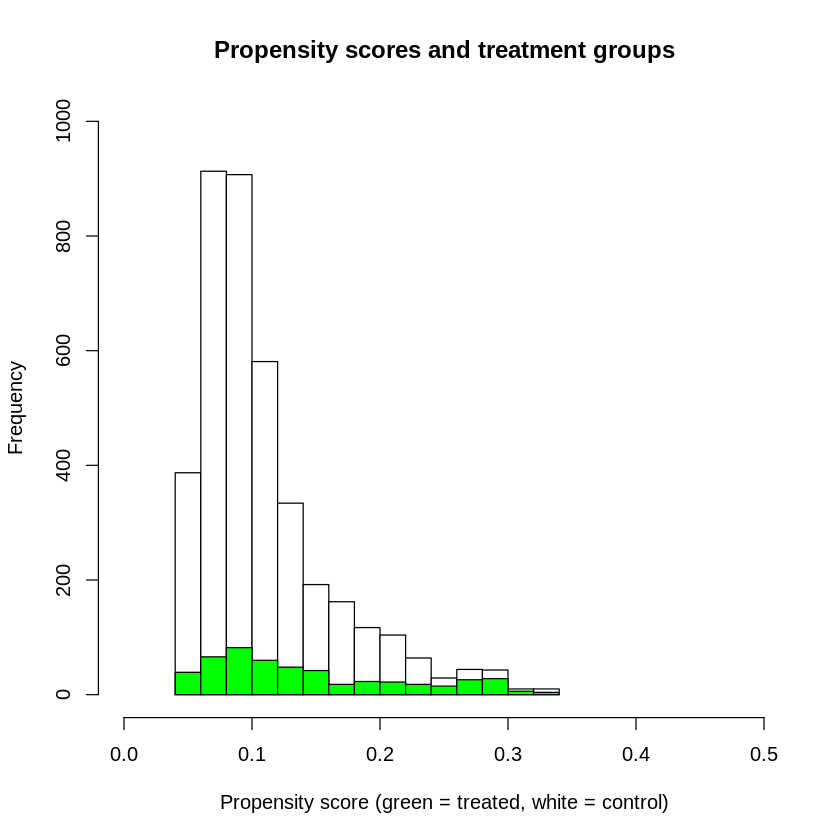

In [ ]:
# Calculate (predict) propensity score for each unit and create dataframe
data_treatment_propscore <- data.frame(pr_score = predict(glm1, type = "response"),
                     treatment = glm1$model$d_threat2006)

# Ideally, visualize prop scores by treatment status (histograms)
# Continue using the prop score for matching...
hist(data_treatment_propscore$pr_score[data_treatment_propscore$treatment==0], xlim=c(0,0.5), ylim=c(0,1000),
     main = "Propensity scores and treatment groups", xlab = "Propensity score (green = treated, white = control)", col = "white")
hist(data_treatment_propscore$pr_score[data_treatment_propscore$treatment==1], add = TRUE, col = "green")

Given the generated propensity scores from the logistic regression, we can estimate the average treatment effect among the treated using the functions of the *Matching* package.

In [ ]:
# save data objects needed for matching
X  <- glm1$fitted ## Propensity Scores as covariates for matching
Y  <- data2$y_trust2006 ## Outcome Variable: Generalized Trust
Tr  <- data2$d_threat2006 ## Treatment Variable: Yes/No question on Feeling Threatened

# Estimating the treatment effect on the treated (the "estimand" option defaults to ATT).
rr  <- Match(Y=Y, Tr=Tr, X=X, M=1)
summary(rr)


Estimate...  -0.65135 
AI SE......  0.12558 
T-stat.....  -5.1867 
p.val......  2.14e-07 

Original number of observations..............  4394 
Original number of treated obs...............  497 
Matched number of observations...............  497 
Matched number of observations  (unweighted).  5901 



The estimated causal effect of feeling threatened to generalized trust is -0.65135, with very low p-value signifying that there is sufficient evidence for a nonzero causal effect.

We can conclude that feeling threatened generally reduce general trust on society.

Let's check for the covariate balance which can support our estimation of the causal effect.

In [ ]:
## MatchBalance() helps us generate balance statistics

mb  <- MatchBalance(d_threat2006 ~ x_age2006 + I(x_age2006^2) + x_education2006 +
               I(x_education2006^2) + x_male2006 + x_income2006,
               data=data2, match.out=rr, nboots=1000)

## Using the cobalt package, we present the statistics thru the bal.tab() function
balance.table <- bal.tab(rr, d_threat2006 ~ x_age2006 + I(x_age2006^2) + x_education2006 +
               I(x_education2006^2) + x_male2006 + x_income2006, data = data2, un= TRUE)
balance.table


***** (V1) x_age2006 *****
                       Before Matching 	 	 After Matching
mean treatment........     35.714 	 	     35.714 
mean control..........     42.054 	 	      35.99 
std mean diff.........    -44.504 	 	    -1.9355 

mean raw eQQ diff.....     6.3581 	 	    0.64769 
med  raw eQQ diff.....          6 	 	          0 
max  raw eQQ diff.....         12 	 	          6 

mean eCDF diff........   0.090769 	 	   0.009475 
med  eCDF diff........   0.090635 	 	  0.0033893 
max  eCDF diff........    0.20444 	 	   0.042196 

var ratio (Tr/Co).....      1.113 	 	     0.9632 
T-test p-value........ < 2.22e-16 	 	    0.39586 
KS Bootstrap p-value.. < 2.22e-16 	 	 < 2.22e-16 
KS Naive p-value...... 2.2204e-16 	 	 5.4696e-05 
KS Statistic..........    0.20444 	 	   0.042196 


***** (V2) I(x_age2006^2) *****
                       Before Matching 	 	 After Matching
mean treatment........       1478 	 	       1478 
mean control..........     1950.8 	 	     1505.5 
std mean diff......

Balance Measures
                        Type Diff.Un Diff.Adj
x_age2006            Contin. -0.4450  -0.0194
I(x_age2006^2)       Contin. -0.4292  -0.0250
x_education2006      Contin. -0.1893   0.0289
I(x_education2006^2) Contin. -0.1443   0.0271
x_male2006            Binary  0.1054  -0.0103
x_income2006         Contin. -0.1449   0.0050

Sample sizes
                     Control Treated
All                  3897.       497
Matched (ESS)        1190.57     497
Matched (Unweighted) 2759.       497
Unmatched            1138.         0

The balance statistics may be too daunting to read and check.

One quick way would be to use the love.plot() function in the *cobalt* package.

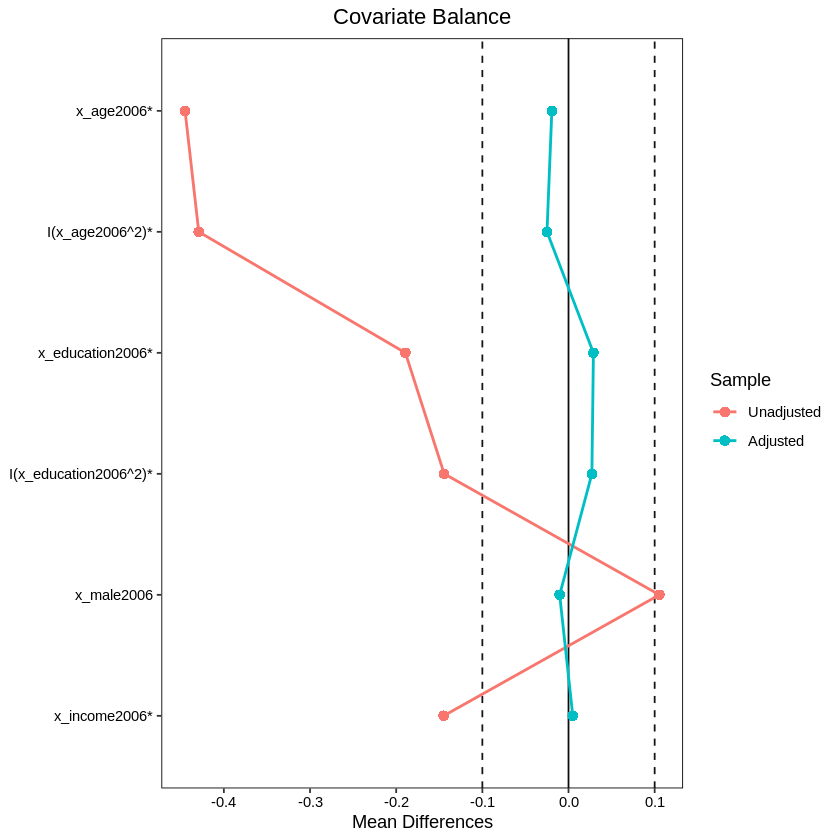

In [ ]:
love.plot(balance.table,
          threshold =.1,
          line = TRUE,
          stars = "std")

### Genetic Matching

Genetic matching uses the genetic algorithm to determine the optimal weights for the covariates to facilitate matching. Propensity score matching and Mahalanobis distance matching are special limiting cases of genetic matching. (Bauer 2020)

#### Genetic Matching for 1 variable

Let's try using genetic matching for a single variable: x_education2006

In [ ]:
# Define covariate matrix, outcome, treatment
  X  <- as.matrix(data2 %>% dplyr::select(x_education2006)) # covariate matrix to be balanced
  Y  <- data2$y_trust2006 # outcome/Response vector
  Tr  <- data2$d_threat2006 # treatment vector

gen1 <- GenMatch(Tr = Tr, X = X,
                 estimand = "ATT",
                 M = 1,
                 replace=FALSE,
                 exact = TRUE,
                 pop.size=16,
                 max.generations=10,
                 wait.generations=1)



Wed Nov 15 08:54:25 2023
Domains:
 0.000000e+00   <=  X1   <=    1.000000e+03 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	2
	(3) Boundary Mutation................. 	2
	(4) Non-Uniform Mutation.............. 	2
	(5) Polytope Crossover................ 	2
	(6) Simple Crossover.................. 	2
	(7) Whole Non-Uniform Mutation........ 	2
	(8) Heuristic Crossover............... 	2
	(9) Local-Minimum Crossover........... 	0

SOFT Maximum Number of Generations: 10
Maximum Nonchanging Generations: 1
Population size       : 16
Convergence Tolerance: 1.000000e-03

Not Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Using Out of Bounds Individuals.

Maximization Problem.
GENERATION: 0 (initializing the population)
Lexical Fit..... 1.000000e+00  1.000000e+00  
#unique......... 16, #Total UniqueCount: 16
var 1:


Now, let's see what the causal effect estimate would be:

In [ ]:
  mgens <- Match(Y=Y, Tr= Tr, X = X,
                 estimand="ATT",
                 M = 1,
                 replace=FALSE,
                 exact = TRUE,
                 Weight.matrix = gen1)
  summary(mgens)


Estimate...  -0.82696 
SE.........  0.14427 
T-stat.....  -5.7321 
p.val......  9.9201e-09 

Original number of observations..............  4394 
Original number of treated obs...............  497 
Matched number of observations...............  497 
Matched number of observations  (unweighted).  497 

Number of obs dropped by 'exact' or 'caliper'  0 



Let's check the balance of our 1 covariate:

In [ ]:
  mb <- MatchBalance(Tr ~  x_education2006,
                     match.out = mgens, nboots = 1000, data = data2)


***** (V1) x_education2006 *****
                       Before Matching 	 	 After Matching
mean treatment........     4.9577 	 	     4.9577 
mean control..........     5.5486 	 	     4.9577 
std mean diff.........    -18.931 	 	          0 

mean raw eQQ diff.....    0.58551 	 	          0 
med  raw eQQ diff.....          0 	 	          0 
max  raw eQQ diff.....          3 	 	          0 

mean eCDF diff........   0.053716 	 	          0 
med  eCDF diff........   0.047811 	 	          0 
max  eCDF diff........    0.10036 	 	          0 

var ratio (Tr/Co).....     1.1602 	 	          1 
T-test p-value........ 6.9401e-05 	 	          1 
KS Bootstrap p-value..      0.001 	 	          1 
KS Naive p-value...... 0.00027872 	 	          1 
KS Statistic..........    0.10036 	 	          0 



#### Genetic Matching with multiple covariates and transformations of covariates

Using the same reduced data from propensity score matching which uses age, education, male, and income variables, let's do a genetic matching approach with multiple variables and functions of those variables.

In [ ]:
X  <- data2 %>% dplyr::select(x_age2006, x_education2006,
                          x_male2006, x_income2006) # Define covariates
Y  <- data2$y_trust2006 # Define outcome/Response vector
Tr  <- data2$d_threat2006 # Define treatment vector

# A matrix containing the variables we wish to achieve balance on.
# Default = X
BalanceMat <- cbind(data2$x_age2006, data2$x_education2006,
                    data2$x_male2006, data2$x_income2006,
                    I(data2$x_age2006^2), I(data2$x_education2006^2),
                    I(data2$x_income2006^2))

Next, we do the genetic matching codes. Population size *pop.size =* should be very large in practice; we will use *pop.size = 16* for a quick run.

In [ ]:
gen1 <- GenMatch(Tr = Tr, X = X,
                 BalanceMatrix = BalanceMat,
                 estimand = "ATT",
                   M = 1,
                   replace=FALSE,
                   exact = TRUE,
                   pop.size=16,
                   max.generations=10,
                   wait.generations=1)



Wed Nov 15 08:54:34 2023
Domains:
 0.000000e+00   <=  X1   <=    1.000000e+03 
 0.000000e+00   <=  X2   <=    1.000000e+03 
 0.000000e+00   <=  X3   <=    1.000000e+03 
 0.000000e+00   <=  X4   <=    1.000000e+03 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	2
	(3) Boundary Mutation................. 	2
	(4) Non-Uniform Mutation.............. 	2
	(5) Polytope Crossover................ 	2
	(6) Simple Crossover.................. 	2
	(7) Whole Non-Uniform Mutation........ 	2
	(8) Heuristic Crossover............... 	2
	(9) Local-Minimum Crossover........... 	0

SOFT Maximum Number of Generations: 10
Maximum Nonchanging Generations: 1
Population size       : 16
Convergence Tolerance: 1.000000e-03

Not Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Using Out of Bounds Individuals.

Maximization Problem.
GENERA

Based on the generated weights of the *GenMatch()* function, let's check the estimated causal effect:

In [ ]:
mgens <- Match(Y=Y, Tr= Tr, X = X,
                 estimand = "ATT",
                   M = 1,
                   replace=FALSE,
                   exact = TRUE,
               Weight.matrix = gen1)
summary(mgens)


Estimate...  -0.61497 
SE.........  0.16026 
T-stat.....  -3.8373 
p.val......  0.00012439 

Original number of observations..............  4394 
Original number of treated obs...............  497 
Matched number of observations...............  374 
Matched number of observations  (unweighted).  374 

Number of obs dropped by 'exact' or 'caliper'  123 



Checking for covariate balance:

In [ ]:
mb <- MatchBalance(Tr ~ x_age2006 + x_education2006 +
                     x_male2006 + x_income2006 +
                     I(x_age2006^2) + I(x_education2006^2) +
                     I(x_income2006^2),
                   match.out = mgens, nboots = 1000, data = data2)


***** (V1) x_age2006 *****
                       Before Matching 	 	 After Matching
mean treatment........     35.714 	 	     34.516 
mean control..........     42.054 	 	     34.516 
std mean diff.........    -44.504 	 	          0 

mean raw eQQ diff.....     6.3581 	 	          0 
med  raw eQQ diff.....          6 	 	          0 
max  raw eQQ diff.....         12 	 	          0 

mean eCDF diff........   0.090769 	 	          0 
med  eCDF diff........   0.090635 	 	          0 
max  eCDF diff........    0.20444 	 	          0 

var ratio (Tr/Co).....      1.113 	 	          1 
T-test p-value........ < 2.22e-16 	 	          1 
KS Bootstrap p-value.. < 2.22e-16 	 	          1 
KS Naive p-value...... 2.2204e-16 	 	          1 
KS Statistic..........    0.20444 	 	          0 


***** (V2) x_education2006 *****
                       Before Matching 	 	 After Matching
mean treatment........     4.9577 	 	     4.6631 
mean control..........     5.5486 	 	     4.6631 
std mean diff.....

Visualizing the balance with the *cobalt* package functions:

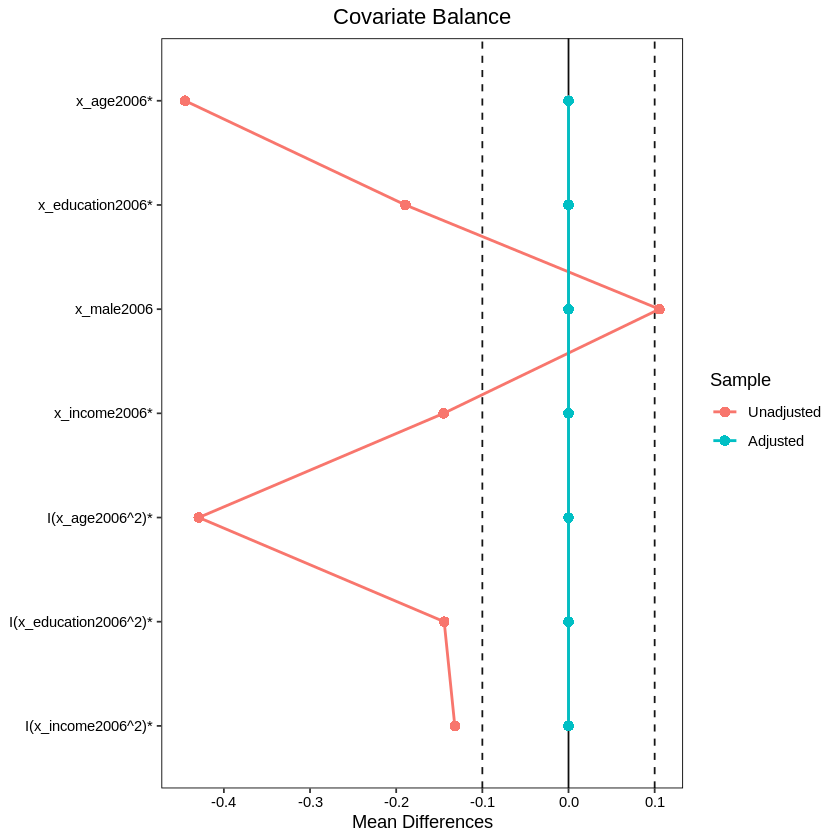

In [ ]:
# Visualize balance with bal.tab (cobalt package)
balance.table <- bal.tab(mgens, d_threat2006 ~ x_age2006 + x_education2006 +
                     x_male2006 + x_income2006 +
                     I(x_age2006^2) + I(x_education2006^2) +
                     I(x_income2006^2), data = data2, un=TRUE)

love.plot(balance.table,
          threshold =.1,
          line = TRUE,
          stars = "std")

# 4) References

Bauer PC (2020). Applied Causal Analysis (with R). https://bookdown.org/paul/applied-causal-analysis/.
> The codes in this work are a good starting point for using R in causal analysis. A good secondary reference for causal inference.

Brumback BA (2022). Fundamentals of Causal Inference with R. CRC Press.
> An advanced level book on causal inference, typically for MS or PhD students. It does require some solid background in probability and statistics.

Cunningham S (2021). Causal Inference: the Mixtape, Yale Press. https://mixtape.scunning.com/.
> A great online book to introduce the complex concepts of causal inference. It is an easily absorbable book for a wider audience, and also has codes for Stata, R, and Python for those who would also like to do some of the examples.

Imai K (2021). STAT 286/GOV 2003: Causal Inference with Applications Lecture Slides. Harvard University. https://imai.fas.harvard.edu/teaching/cause.html.
> Imai's online lecture page where you can access his slides. He does have a Youtube lecture series on causal inference here: https://www.youtube.com/@imaikosuke.

Nguyen M (2020). A Guide on Data Analysis. Bookdown. https://bookdown.org/mike/data_analysis/
> A comprehensive book on data analysis with a section on causal inference. A good starting point for reading on and doing some data analytics learning with R codes.

O'Grady T (2020). Causal Inference for Beginning Undergraduates, https://github.com/verenakunz/Causal-Inference-for-Beginning-Undergraduates/tree/master.
> A good learning reference for those who also like to do some exercises with solutions

